#### Problem 2

**a.)** For steepest descent, the number of iterations for convergence for each resolution are:

- 8 x 8: 190 iterations
- 16 x 16: 303 iterations
- 32 x 32: 382 iterations
- 64 x 64: 824 iterations

The number of iterations seems to grow significantly with increases in parameter dimensionality. We can easily see that the steepest descent method does not scale well.

**b.)** For Newton-CG, the number of iterations for convergence for each resolution are:

- 8 x 8: 6 iterations (32 CG iterations)
- 16 x 16: 7 iterations (39 CG iterations)
- 32 x 32: 7 iterations (40 CG iterations)
- 64 x 64: 7 iterations (38 CG iterations)

The number of iterations for the Newton-CG method does not seem to change significantly with increases in parameter dimension. This makes it much more scalable than steepest descent.

**c.)** Below are plots representing the eigenvalues and eigenvectors of the Hessian misfit at the solution of the inverse problem for domains of 8 x 8, 16 x 16, 32 x 32, and 64 x 64. 

Of note is the fact that the eigenvalues do not seem to change significantly even with increasing domain sizes.

The eigenvectors of the Hessian misfit seem to converge to a particular pattern with increasing domain size. The higher the eigenvector, the greater the domain it seems to need to converge. This can easily be seen by comparing eigenvectors 0,1,2 with 5,10,15 across the domains.

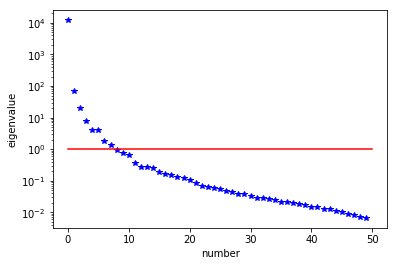
<div align="center">8 x 8 Eigenvalues</div>

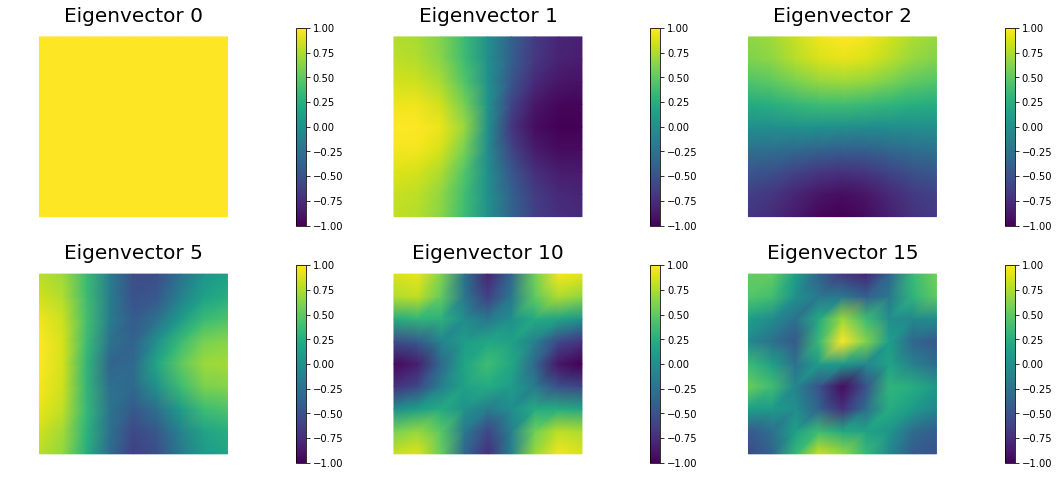
<div align="center">8 x 8 Eigenvectors</div>

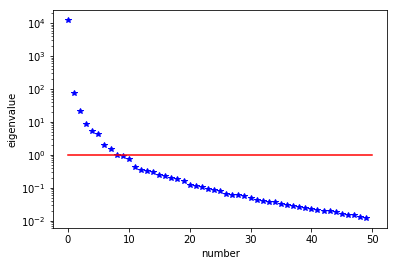
<div align="center">16 x 16 Eigenvalues</div>

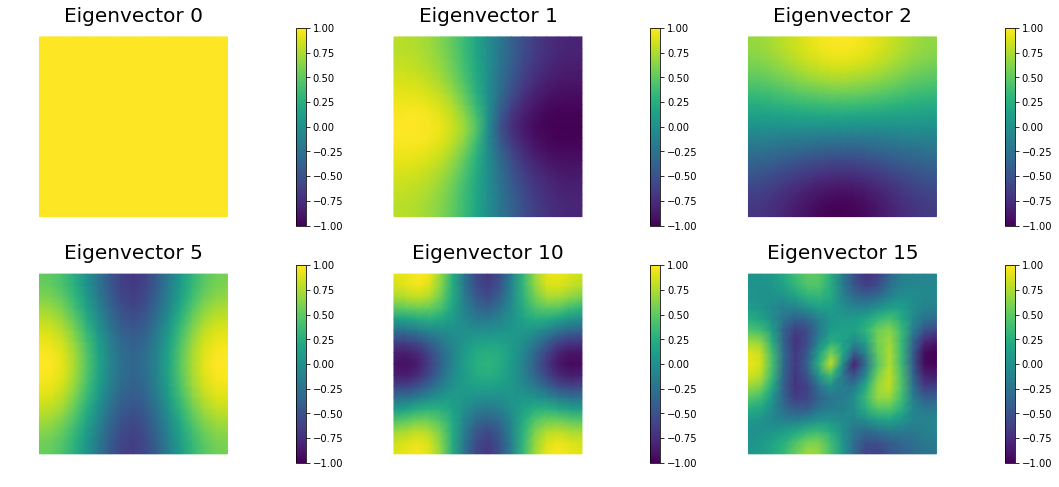
<div align="center">8 x 8 Eigenvectors</div>

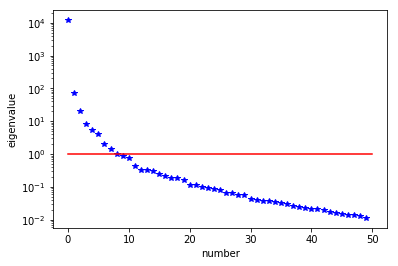
<div align="center">32 x 32 Eigenvalues</div>

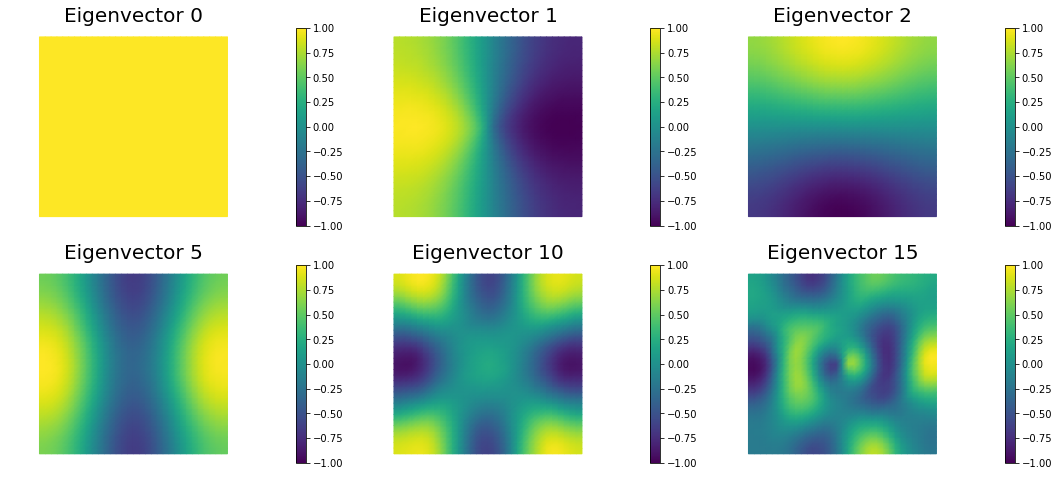
<div align="center">8 x 8 Eigenvectors</div>

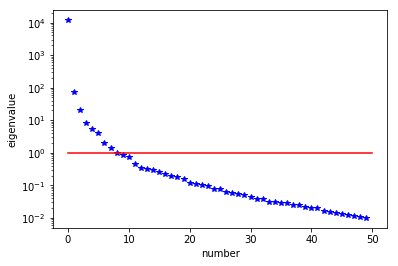
<div align="center">64 x 64 Eigenvalues</div>

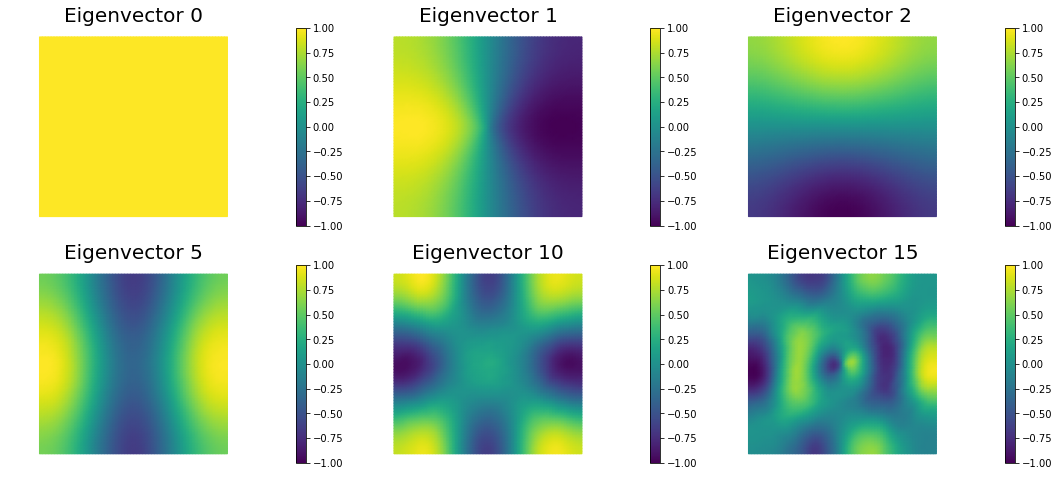
<div align="center">8 x 8 Eigenvectors</div>



**d.)**

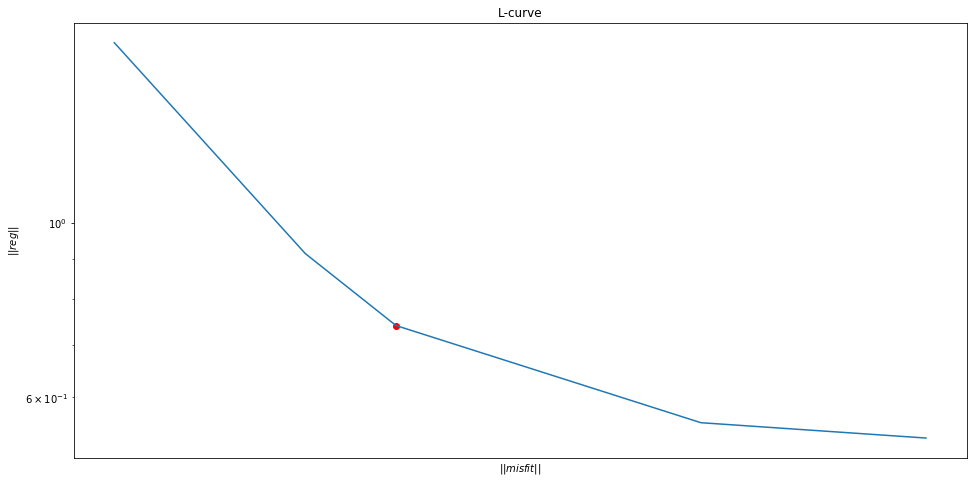
<div align="center">L-Curve (SD)</div>

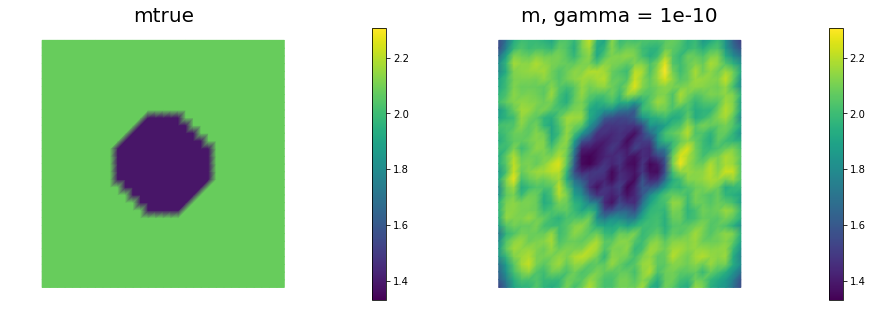

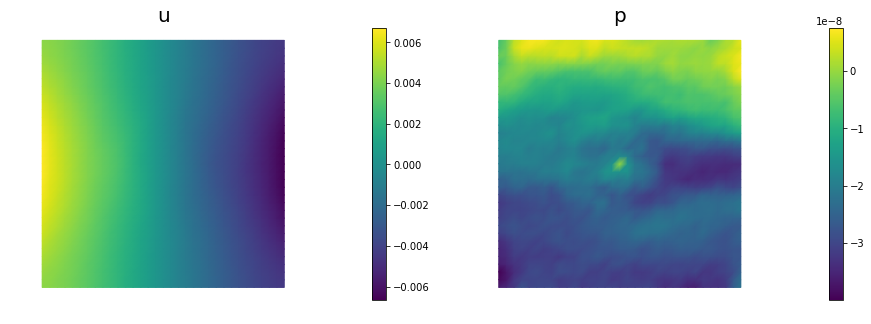
<div align="center">Optimal Gamma (SD)</div>

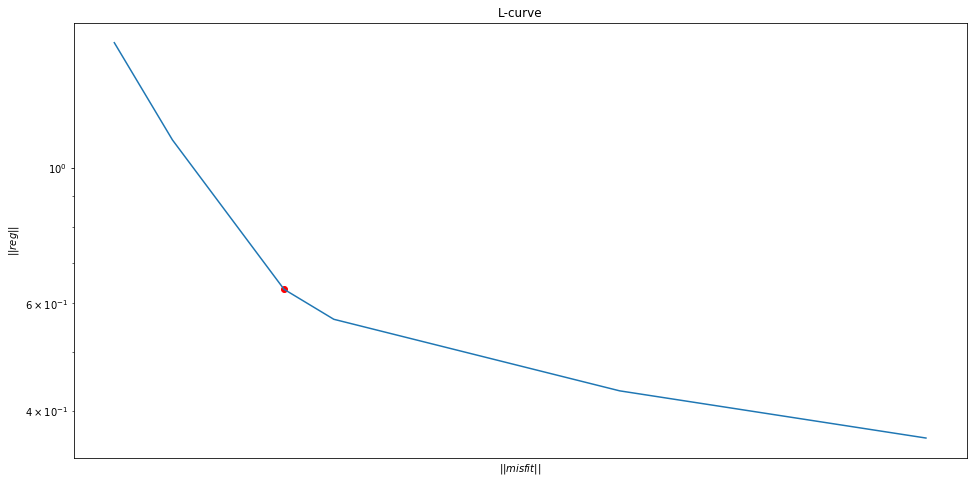
<div align="center">L-Curve (INCG)</div>

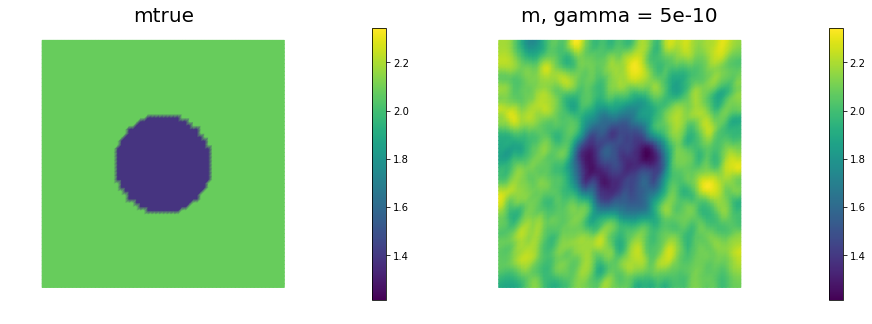

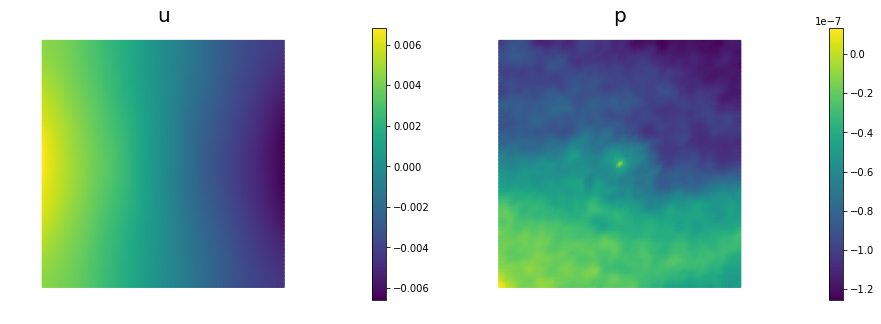
<div align="center">Optimal Gamma (INCG)</div>

In [ ]:
"""
    Part d code block (modified Poisson_SD.ipynb)
"""
# Regularization parameter for l-curve
gammas = [1e-9,0.5e-9,1e-10,0.5e-10,1e-11]

# Define cost function
def cost(u, d, m, gamma, beta=0.1):
    #reg = 0.5*dl.assemble( dl.inner(dl.grad(m), dl.grad(m))*dl.dx )
    reg = 0.5*dl.assemble( ((dl.inner(dl.grad(m), dl.grad(m)) + beta)**0.5)*dl.dx ) 
    misfit = 0.5 * dl.assemble( (u-d)**2*dl.dx)
    return [gamma*reg + misfit, misfit, reg]

# define parameters for the optimization
tol = 1e-4
maxiter = 1000
print_any = 10
plot_any = 50
c_armijo = 1e-5

# initialize iter counters
iter = 0
converged = False

# initializations
g = dl.Vector()
M.init_vector(g,0)
m_prev = dl.Function(Vm)

# save misfit, reg, and m
f_reg = list()
f_misfit = list()
f_m = list()
f_u = list()
f_p = list()

for gamma in gammas:
    print( "Nit  cost          misfit        reg         ||grad||       alpha  N backtrack" )

    # weak form for setting up the state equation
    a_state = dl.inner( dl.exp(m) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
    L_state = j * u_test * dl.ds

    # weak form for setting up the adjoint equations
    a_adj = dl.inner( dl.exp(m) * dl.grad(p_trial), dl.grad(p_test) ) * dl.dx
    L_adj = - dl.inner(u - d, p_test) * dl.dx

    # weak form for gradient
    grad_misfit = dl.inner(dl.exp(m)*m_test*dl.grad(u), dl.grad(p)) * dl.dx
    grad_reg    = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx

    # Mass matrix in parameter space
    Mvarf    = dl.inner(m_trial, m_test) * dl.dx
    M = dl.assemble(Mvarf)
    
    m.assign(m0)

    # solve state equation
    A, state_b = dl.assemble_system (a_state, L_state, bc_state)
    dl.solve(A, u.vector(), state_b)

    # evaluate cost
    [cost_old, misfit_old, reg_old] = cost(u, d, m, gamma)
    
    while iter <  maxiter and not converged:
        
        # solve the adoint problem
        adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
        dl.solve(adj_A, p.vector(), adjoint_RHS)

        # evaluate the  gradient
        MG = dl.assemble(grad_misfit + grad_reg)
        dl.solve(M, g, MG)

        # calculate the norm of the gradient
        grad_norm2 = g.inner(MG)
        gradnorm = np.sqrt(grad_norm2)

        if iter == 0:
            gradnorm0 = gradnorm

        # linesearch
        it_backtrack = 0
        m_prev.assign(m)
        alpha = 1.e5
        backtrack_converged = False
        for it_backtrack in range(20):
            m.vector().axpy(-alpha, g )

            # solve the forward problem
            state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
            dl.solve(state_A, u.vector(), state_b)

            # evaluate cost
            [cost_new, misfit_new, reg_new] = cost(u, d, m, gamma)

            # check if Armijo conditions are satisfied
            if cost_new < cost_old - alpha * c_armijo * grad_norm2:
                cost_old = cost_new
                backtrack_converged = True
                break
            else:
                alpha *= 0.5
                m.assign(m_prev)  # reset m
        
        if backtrack_converged == False:
            print( "Backtracking failed. A sufficient descent direction was not found" )
            converged = False
            break

        sp = ""
        if (iter % print_any)== 0 :
            print( "%3d %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %3d" % \
                (iter, sp, cost_new, sp, misfit_new, sp, reg_new, sp, \
                gradnorm, sp, alpha, sp, it_backtrack) )

        #if (iter % plot_any)== 0 :
        #    nb.multi1_plot([m,u,p], ["m","u","p"], same_colorbar=False)
        #    plt.show()

        # check for convergence
        if gradnorm < tol*gradnorm0 and iter > 0:
            converged = True
            print ("Steepest descent converged in ",iter,"  iterations")

        iter += 1

    if not converged:
        print ( "Steepest descent did not converge in ", maxiter, " iterations")

    # save regs and misfits
    f_reg.append(reg_new)
    f_misfit.append(misfit_new)
    f_m.append(m)
    f_u.append(u)
    f_p.append(p)
        
    # reinitialize iter counters
    iter = 0
    converged = False

    # reinitializations
    g = dl.Vector()
    M.init_vector(g,0)
    m_prev = dl.Function(Vm)

In [ ]:
"""
    Part d code block (modified Poisson_INCG.ipynb)
"""
# test gamma with l-curve criterion
gammas = [1e-8,0.5e-8,1e-9,0.5e-9,1e-10,0.5e-10]

# define cost function
def cost(u, d, m, gamma, beta=0.1):
    #reg = 0.5* dl.assemble( dl.inner(dl.grad(m), dl.grad(m))*dl.dx )
    reg = 0.5*dl.assemble( ((dl.inner(dl.grad(m), dl.grad(m)) + beta)**0.5)*dl.dx )
    misfit = 0.5 * dl.assemble( (u-d)**2*dl.dx)
    return [gamma*reg + misfit, misfit, reg]

# define parameters for the optimization
tol = 1e-8
c = 1e-4
maxiter = 12
plot_on = False

# initialize iter counters
iter = 1
total_cg_iter = 0
converged = False

# initializations
g, m_delta = dl.Vector(), dl.Vector()
R.init_vector(m_delta,0)
R.init_vector(g,0)
m_prev = dl.Function(Vm)

# save misfit, reg, and m,u,p
f_reg = list()
f_misfit = list()
f_m = list()
f_u = list()
f_p = list()

for gamma in gammas:
    # weak form for setting up the state equation
    a_state = dl.inner(dl.exp(m) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
    L_state = dl.inner(j, u_test) * dl.ds

    # weak form for setting up the adjoint equation
    a_adj = dl.inner(dl.exp(m) * dl.grad(p_trial), dl.grad(p_test)) * dl.dx
    L_adj = -dl.inner(u - d, p_test) * dl.dx

    # weak form for gradient
    grad_misfit    = dl.inner(dl.exp(m)*m_test*dl.grad(u), dl.grad(p)) * dl.dx
    grad_reg = gamma*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx

    # L^2 weighted inner product
    M_varf   = dl.inner(m_trial, m_test) * dl.dx
    M = dl.assemble(M_varf)
    
    m0 = dl.interpolate(dl.Constant(np.log(4.) ), Vm )

    m.assign(m0)

    # solve state equation
    state_A, state_b = dl.assemble_system (a_state, L_state, bc_state)
    dl.solve (state_A, u.vector(), state_b)

    # evaluate cost
    [cost_old, misfit_old, reg_old] = cost(u, d, m, gamma)
    
    W_varf   = dl.inner(u_trial, u_test) * dl.dx
    R_varf   = dl.Constant(gamma) * dl.inner(dl.grad(m_trial), dl.grad(m_test)) * dl.dx

    C_varf   = dl.inner(dl.exp(m) * m_trial * dl.grad(u), dl.grad(u_test)) * dl.dx
    Wum_varf = dl.inner(dl.exp(m) * m_trial * dl.grad(p_test), dl.grad(p)) * dl.dx
    Wmm_varf = dl.inner(dl.exp(m) * m_trial * m_test *  dl.grad(u),  dl.grad(p)) * dl.dx

    # Assemble constant matrices
    W = dl.assemble(W_varf)
    R = dl.assemble(R_varf)
    
    print( "Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg" )

    while iter <  maxiter and not converged:

        # solve the adoint problem
        adjoint_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
        dl.solve(adjoint_A, p.vector(), adjoint_RHS)

        # evaluate the  gradient
        MG = dl.assemble(grad_misfit + grad_reg)

        # calculate the L^2 norm of the gradient
        dl.solve(M, g, MG)
        grad2 = g.inner(MG)
        gradnorm = np.sqrt(grad2)

        # set the CG tolerance (use Eisenstat–Walker termination criterion)
        if iter == 1:
            gradnorm_ini = gradnorm
        tolcg = min(0.5, np.sqrt(gradnorm/gradnorm_ini))

        # assemble W_um and W_mm
        C   = dl.assemble(C_varf)
        Wum = dl.assemble(Wum_varf)
        Wmm = dl.assemble(Wmm_varf)

        # define the Hessian apply operator (with preconditioner)
        Hess_Apply = HessianOperator(R, Wmm, C, state_A, adjoint_A, W, Wum, bc_adj, use_gaussnewton=(iter<6) )
        P = R + 0.1*gamma * M
        Psolver = dl.PETScKrylovSolver("cg", amg_method())
        Psolver.set_operator(P)

        solver = CGSolverSteihaug()
        solver.set_operator(Hess_Apply)
        solver.set_preconditioner(Psolver)
        solver.parameters["rel_tolerance"] = tolcg
        solver.parameters["zero_initial_guess"] = True
        solver.parameters["print_level"] = -1

        # solve the Newton system H a_delta = - MG
        solver.solve(m_delta, -MG)
        total_cg_iter += Hess_Apply.cgiter

        # linesearch
        alpha = 1
        descent = 0
        no_backtrack = 0
        m_prev.assign(m)
        while descent == 0 and no_backtrack < 10:
            m.vector().axpy(alpha, m_delta )

            # solve the state/forward problem
            state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
            dl.solve(state_A, u.vector(), state_b)

            # evaluate cost
            [cost_new, misfit_new, reg_new] = cost(u, d, m, gamma)

            # check if Armijo conditions are satisfied
            if cost_new < cost_old + alpha * c * MG.inner(m_delta):
                cost_old = cost_new
                descent = 1
            else:
                no_backtrack += 1
                alpha *= 0.5
                m.assign(m_prev)  # reset a

        # calculate sqrt(-G * D)
        graddir = np.sqrt(- MG.inner(m_delta) )

        sp = ""
        print( "%2d %2s %2d %3s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %5.2f %1s %5.3e" % \
            (iter, sp, Hess_Apply.cgiter, sp, cost_new, sp, misfit_new, sp, reg_new, sp, \
             graddir, sp, gradnorm, sp, alpha, sp, tolcg) )

        if plot_on:
            nb.multi1_plot([m,u,p], ["m","u","p"], same_colorbar=False)
            plt.show()

        # check for convergence
        if gradnorm < tol and iter > 1:
            converged = True
            print( "Newton's method converged in ",iter,"  iterations" )
            print( "Total number of CG iterations: ", total_cg_iter )

        iter += 1

    if not converged:
        print( "Newton's method did not converge in ", maxiter, " iterations" )
        
    # save regs and misfits
    f_reg.append(reg_new)
    f_misfit.append(misfit_new)
    f_m.append(m)
    f_u.append(u)
    f_p.append(p)
        
    # reinitialize iter counters
    iter = 1
    total_cg_iter = 0
    converged = False

    # reinitializations
    g, m_delta = dl.Vector(), dl.Vector()
    R.init_vector(m_delta,0)
    R.init_vector(g,0)